<a href="https://colab.research.google.com/github/akimi-yano/climbing-footwork-classification/blob/main/Climbing_Footwork_Classification_LLM_GPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary

In this Google Colab file, I experimented using LLM for image classification instead of training neural network. I used GPT API on a set of sample images I collected on the internet.





# Install Dependencies

In [1]:
!pip install torch torchvision transformers openai

  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
Using cached nvidia_cublas_

# Import Libraries

In [2]:
# Google drive
from google.colab import drive

# Python libraries
import random
import itertools

# Basic libraries for data science
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
import seaborn as sns


# System libraries
import os
from pathlib import Path
import os.path
from getpass import getpass

# Image Processing
from PIL import Image, ImageChops, ImageEnhance
import cv2

# Metrics
from sklearn.metrics import confusion_matrix, classification_report, classification_report

# OpenAI
from openai import OpenAI

import warnings
warnings.filterwarnings('ignore')

In [31]:
import torch
from torchvision import transforms

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
drive.mount('/content/drive')
# input_dir = '/content/drive/MyDrive/ml-climbing-project/raw-climbing_footwork_mini_dataset' # This is for testing
input_dir = '/content/drive/MyDrive/ml-climbing-project/raw-climbing_footwork_large_dataset'
val = os.listdir(input_dir)
print(val)

Mounted at /content/drive
['toe_hook', 'others', 'heel_hook']


# Helper Functions

In [5]:
def check_image_format(input_dir):
  for dirpath, dirnames, filenames in os.walk(input_dir):
    for i, filename in enumerate(filenames):
      filepath = os.path.join(dirpath, filename)
      try:
          with Image.open(filepath) as img:

            print(f"Index: {i} - File Path: {filepath} - Actual Format: {img.format}") # The format should be PNG after Format Adjusting.
      except Exception as e:
          print(f"Error: {e}")

# Load Data

In [6]:
for dirpath, dirnames, filenames in os.walk(input_dir):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in '/content/drive/MyDrive/ml-climbing-project/raw-climbing_footwork_large_dataset'.
There are 0 directories and 77 images in '/content/drive/MyDrive/ml-climbing-project/raw-climbing_footwork_large_dataset/toe_hook'.
There are 0 directories and 124 images in '/content/drive/MyDrive/ml-climbing-project/raw-climbing_footwork_large_dataset/others'.
There are 0 directories and 106 images in '/content/drive/MyDrive/ml-climbing-project/raw-climbing_footwork_large_dataset/heel_hook'.


In [7]:
check_image_format(input_dir)

Index: 0 - File Path: /content/drive/MyDrive/ml-climbing-project/raw-climbing_footwork_large_dataset/toe_hook/img9.png - Actual Format: PNG
Index: 1 - File Path: /content/drive/MyDrive/ml-climbing-project/raw-climbing_footwork_large_dataset/toe_hook/img8.png - Actual Format: PNG
Index: 2 - File Path: /content/drive/MyDrive/ml-climbing-project/raw-climbing_footwork_large_dataset/toe_hook/img7.png - Actual Format: PNG
Index: 3 - File Path: /content/drive/MyDrive/ml-climbing-project/raw-climbing_footwork_large_dataset/toe_hook/img1.png - Actual Format: PNG
Index: 4 - File Path: /content/drive/MyDrive/ml-climbing-project/raw-climbing_footwork_large_dataset/toe_hook/img10.png - Actual Format: PNG
Index: 5 - File Path: /content/drive/MyDrive/ml-climbing-project/raw-climbing_footwork_large_dataset/toe_hook/result0_0.jpg - Actual Format: JPEG
Index: 6 - File Path: /content/drive/MyDrive/ml-climbing-project/raw-climbing_footwork_large_dataset/toe_hook/result0_1.jpg - Actual Format: JPEG
Index: 

# Adjust the Format to be PNG

Since the images I collected from the internet had different file formats, I converted the image files to have PNG format.


In [8]:
formatted__output_dir = '/content/drive/MyDrive/ml-climbing-project/formatted-climbing_footwork_large_dataset'

# Create output directory if it doesn't exist
if not os.path.exists(formatted__output_dir):
    os.makedirs(formatted__output_dir)
    print(f"Directory '{formatted__output_dir}' created.")
else:
    print(f"Directory '{formatted__output_dir}' already exists.")

# Traverse subdirectories and process files
for dir_name in os.listdir(input_dir):
    sub_dir_path = os.path.join(input_dir, dir_name)
    if os.path.isdir(sub_dir_path):
        for file_name in os.listdir(sub_dir_path):
            if file_name.endswith(('.WEBP', '.JPEG', '.webp', '.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                file_path = os.path.join(sub_dir_path, file_name)  # Full path to the file
                print(f"Processing: {file_path}")
                try:
                    with Image.open(file_path) as img:
                        # Save the image as PNG
                        output_sub_dir = os.path.join(formatted__output_dir, dir_name)
                        os.makedirs(output_sub_dir, exist_ok=True)  # Create subdirectory if it doesn't exist
                        output_path = os.path.join(output_sub_dir, os.path.splitext(file_name)[0] + ".png")
                        img.save(output_path, format="PNG")
                        print(f"Saved as PNG: {output_path}")
                except Exception as e:
                    print(f"Failed to process {file_name}: {e}")

Directory '/content/drive/MyDrive/ml-climbing-project/formatted-climbing_footwork_large_dataset' already exists.
Processing: /content/drive/MyDrive/ml-climbing-project/raw-climbing_footwork_large_dataset/toe_hook/img9.png
Saved as PNG: /content/drive/MyDrive/ml-climbing-project/formatted-climbing_footwork_large_dataset/toe_hook/img9.png
Processing: /content/drive/MyDrive/ml-climbing-project/raw-climbing_footwork_large_dataset/toe_hook/img8.png
Saved as PNG: /content/drive/MyDrive/ml-climbing-project/formatted-climbing_footwork_large_dataset/toe_hook/img8.png
Processing: /content/drive/MyDrive/ml-climbing-project/raw-climbing_footwork_large_dataset/toe_hook/img7.png
Saved as PNG: /content/drive/MyDrive/ml-climbing-project/formatted-climbing_footwork_large_dataset/toe_hook/img7.png
Processing: /content/drive/MyDrive/ml-climbing-project/raw-climbing_footwork_large_dataset/toe_hook/img1.png
Saved as PNG: /content/drive/MyDrive/ml-climbing-project/formatted-climbing_footwork_large_dataset/t

In [9]:
check_image_format(formatted__output_dir)

Index: 0 - File Path: /content/drive/MyDrive/ml-climbing-project/formatted-climbing_footwork_large_dataset/toe_hook/img9.png - Actual Format: PNG
Index: 1 - File Path: /content/drive/MyDrive/ml-climbing-project/formatted-climbing_footwork_large_dataset/toe_hook/img1.png - Actual Format: PNG
Index: 2 - File Path: /content/drive/MyDrive/ml-climbing-project/formatted-climbing_footwork_large_dataset/toe_hook/img8.png - Actual Format: PNG
Index: 3 - File Path: /content/drive/MyDrive/ml-climbing-project/formatted-climbing_footwork_large_dataset/toe_hook/img7.png - Actual Format: PNG
Index: 4 - File Path: /content/drive/MyDrive/ml-climbing-project/formatted-climbing_footwork_large_dataset/toe_hook/result0_1.png - Actual Format: PNG
Index: 5 - File Path: /content/drive/MyDrive/ml-climbing-project/formatted-climbing_footwork_large_dataset/toe_hook/img10.png - Actual Format: PNG
Index: 6 - File Path: /content/drive/MyDrive/ml-climbing-project/formatted-climbing_footwork_large_dataset/toe_hook/re

In [10]:
for dirpath, dirnames, filenames in os.walk(formatted__output_dir):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in '/content/drive/MyDrive/ml-climbing-project/formatted-climbing_footwork_large_dataset'.
There are 0 directories and 76 images in '/content/drive/MyDrive/ml-climbing-project/formatted-climbing_footwork_large_dataset/toe_hook'.
There are 0 directories and 124 images in '/content/drive/MyDrive/ml-climbing-project/formatted-climbing_footwork_large_dataset/others'.
There are 0 directories and 106 images in '/content/drive/MyDrive/ml-climbing-project/formatted-climbing_footwork_large_dataset/heel_hook'.


# Place the Dataset into Dataframe

In [11]:
image_dir = Path(formatted__output_dir)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
print("Filepath length: ", len(filepaths))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
print("Labels length: ", len(labels))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

Filepath length:  306
Labels length:  306


In [12]:
image_df

Filepath      Label
0    /content/drive/MyDrive/ml-climbing-project/for...   toe_hook
1    /content/drive/MyDrive/ml-climbing-project/for...   toe_hook
2    /content/drive/MyDrive/ml-climbing-project/for...   toe_hook
3    /content/drive/MyDrive/ml-climbing-project/for...   toe_hook
4    /content/drive/MyDrive/ml-climbing-project/for...   toe_hook
..                                                 ...        ...
301  /content/drive/MyDrive/ml-climbing-project/for...  heel_hook
302  /content/drive/MyDrive/ml-climbing-project/for...  heel_hook
303  /content/drive/MyDrive/ml-climbing-project/for...  heel_hook
304  /content/drive/MyDrive/ml-climbing-project/for...  heel_hook
305  /content/drive/MyDrive/ml-climbing-project/for...  heel_hook

[306 rows x 2 columns]

In [13]:
image_df['Label'].value_counts()

Label
others       124
heel_hook    106
toe_hook      76
Name: count, dtype: int64

# Visualize Images from the Dataset

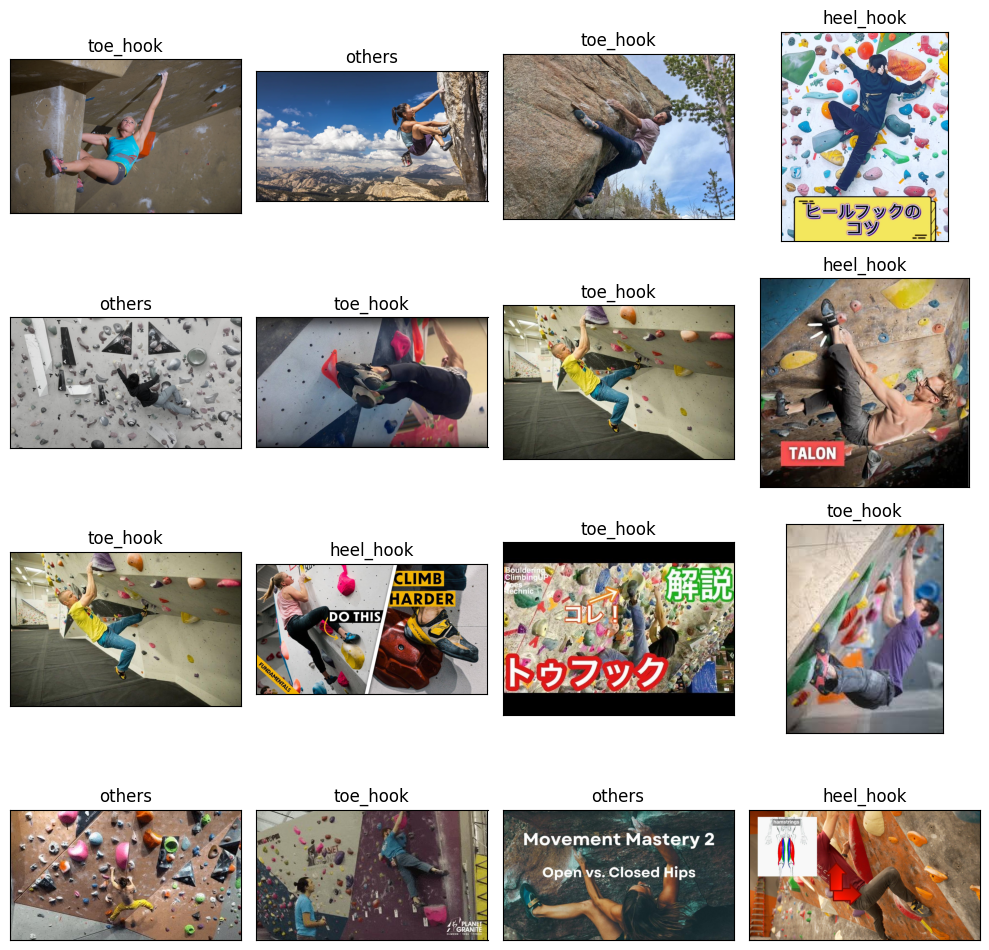

In [14]:
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10,10), subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
  ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
  ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()

# Error Level Analysis (ELA)

Creating a visualization of Error Level Analysis (ELA) for a random image selected from the dataset's heel_hook class.

Here are the purposes of this analysis:

1.   Identify image tampering or anomalies: ELA highlights subtle changes in compression artifacts, which can reveal areas of the image that have been altered or manipulated.
2.   Understand compression effects: By varying JPEG quality, you can observe how artifacts change at different compression levels.

In [15]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff

def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGBA')
    image.save(temp_filename, 'RGBA', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image

def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')

    items = list(items)

    p = random.choice(items)
    return p.as_posix()

# View random sample from the dataset
p = random_sample(formatted__output_dir+'/heel_hook')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

# Split the Dataset

In [16]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.8, shuffle=True, random_state=12)

In [17]:
train_df

Filepath      Label
157  /content/drive/MyDrive/ml-climbing-project/for...     others
20   /content/drive/MyDrive/ml-climbing-project/for...   toe_hook
272  /content/drive/MyDrive/ml-climbing-project/for...  heel_hook
237  /content/drive/MyDrive/ml-climbing-project/for...  heel_hook
235  /content/drive/MyDrive/ml-climbing-project/for...  heel_hook
..                                                 ...        ...
259  /content/drive/MyDrive/ml-climbing-project/for...  heel_hook
130  /content/drive/MyDrive/ml-climbing-project/for...     others
241  /content/drive/MyDrive/ml-climbing-project/for...  heel_hook
253  /content/drive/MyDrive/ml-climbing-project/for...  heel_hook
155  /content/drive/MyDrive/ml-climbing-project/for...     others

[61 rows x 2 columns]

In [18]:
test_df

Filepath      Label
151  /content/drive/MyDrive/ml-climbing-project/for...     others
280  /content/drive/MyDrive/ml-climbing-project/for...  heel_hook
220  /content/drive/MyDrive/ml-climbing-project/for...  heel_hook
217  /content/drive/MyDrive/ml-climbing-project/for...  heel_hook
192  /content/drive/MyDrive/ml-climbing-project/for...     others
..                                                 ...        ...
279  /content/drive/MyDrive/ml-climbing-project/for...  heel_hook
43   /content/drive/MyDrive/ml-climbing-project/for...   toe_hook
179  /content/drive/MyDrive/ml-climbing-project/for...     others
197  /content/drive/MyDrive/ml-climbing-project/for...     others
105  /content/drive/MyDrive/ml-climbing-project/for...     others

[245 rows x 2 columns]

In [19]:
label_map = {
    'heel_hook': 0,
    'toe_hook': 1,
    'others': 2
}

In [20]:
class_mapping = {
    0: 'heel_hook',
    1: 'toe_hook',
    2: 'others'
}

In [21]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import torch
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.label_map = label_map

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['Filepath']
        label = self.dataframe.iloc[idx]['Label']
        label_idx = self.label_map[label]

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label_idx)  # Return image + numeric label

In [22]:
train_dataset = CustomImageDataset(train_df, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
for images, labels in train_loader:
    print(images.shape, labels)

torch.Size([32, 3, 224, 224]) tensor([0, 0, 0, 0, 1, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 1,
        1, 0, 0, 2, 0, 0, 2, 1])
torch.Size([29, 3, 224, 224]) tensor([0, 2, 2, 2, 1, 2, 2, 0, 1, 2, 1, 2, 0, 0, 1, 2, 2, 0, 2, 0, 0, 0, 0, 0,
        2, 0, 2, 2, 2])


In [23]:
test_dataset = CustomImageDataset(test_df, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
for images, labels in test_loader:
    print(images.shape, labels)
    break

torch.Size([32, 3, 224, 224]) tensor([2, 0, 0, 0, 2, 0, 2, 2, 1, 0, 1, 0, 0, 2, 0, 2, 2, 1, 1, 2, 0, 0, 0, 0,
        2, 0, 2, 2, 1, 2, 0, 1])


# Set up the LLM

In [24]:
os.environ['OPENAI_API_KEY'] = getpass('Enter your OpenAI API Key: ')

Enter your OpenAI API Key: ··········


In [25]:
import openai
import base64
import io
import torchvision.transforms as transforms
from PIL import Image

# OpenAI API client
client = openai.OpenAI()

# Convert tensor to PIL image
to_pil = transforms.ToPILImage()

def encode_image_base64(image):
    """
    Converts a PIL image to a base64-encoded string.
    """
    img_byte_array = io.BytesIO()
    image.save(img_byte_array, format="JPEG")
    img_byte_array.seek(0)  # Move pointer to the start
    return base64.b64encode(img_byte_array.read()).decode('utf-8')

def classify_with_gpt(image):
    """
    Classifies an image using GPT-4V.
    Uses base64 encoding instead of an online URL.
    Returns an integer: 0 (heel_hook), 1 (toe_hook), or 2 (others).
    """

    # Encode image as base64
    encoded_image = encode_image_base64(image)

    # Define prompt & messages
    messages = [
        {"role": "user", "content": [
            {"type": "text", "text": """
            You are an expert in rock climbing techniques. Classify the given image into one of these categories:
            - 0 (heel_hook): If the climber's **heel** is hooked onto a hold.
            - 1 (toe_hook): If the climber's **toe** is hooked onto a hold.
            - 2 (others): If neither technique is present.

            **Respond with only a single integer (0, 1, or 2). Do not include any explanation or text.**
            """},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encoded_image}"}}
        ]}
    ]

    # print("Making a call to gpt with the messages: ", messages)

    # API call to classify a single image
    response = client.chat.completions.create(
        model="gpt-4-turbo",
        messages=messages,
        max_tokens=1  # Limit response to one token (single integer)
    )
    # print("Got the Response: ", response)

    # Extract and return integer prediction
    prediction = response.choices[0].message.content.strip()

    try:
        return int(prediction)  # Convert to integer
    except ValueError:
        return 3  # Default value if response is unexpected

# Making Predictions on the Test Data

In [26]:
# Make predictions for test data from test_loader
true_labels = []
predicted_labels = []
all_images = []

for i, (images, labels) in enumerate(test_loader):
    for idx, (img, label) in enumerate(zip(images, labels)):
        img_pil = to_pil(img)  # Convert tensor to PIL image
        all_images.append(img)
        predicted_labels.append(classify_with_gpt(img_pil))
        true_labels.append(label.item())
    break

In [27]:
print("# of true labels: ", len(true_labels))
print("# of predicted labels: ", len(predicted_labels))
print("# of all images: ", len(all_images))

# of true labels:  32
# of predicted labels:  32
# of all images:  32


In [28]:
# Display classification results

def unnormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(tensor.device)
    tensor = tensor * std + mean  # Reverse normalization
    return tensor

# Number of images to display per row
num_cols = 5
num_rows = len(true_labels) // num_cols + 1

# Create figure
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

# Flatten axes for easy iteration
axes = axes.flatten()

# Iterate through images, labels, and predictions
for idx, (image, true_label, predicted_label) in enumerate(zip(all_images, true_labels, predicted_labels)):
    if idx >= len(axes):
        break  # Stop if we exceed the available subplot slots

    img = unnormalize(image)
    img = img.permute(1, 2, 0)

    # Display the image
    axes[idx].imshow(img)
    axes[idx].axis("off")

    # Add title with True & Predicted labels
    true_text = f"True: {class_mapping[true_label]}"
    pred_text = f"Pred: {class_mapping[predicted_label]}"
    axes[idx].set_title(f"{true_text}\n{pred_text}", fontsize=10, color="red" if true_label != predicted_label else "green")

# Remove empty subplots
for ax in axes[idx + 1:]:
    ax.axis("off")

plt.tight_layout()
plt.show()

# Plotting the Confusion Matrix and Classification Reports

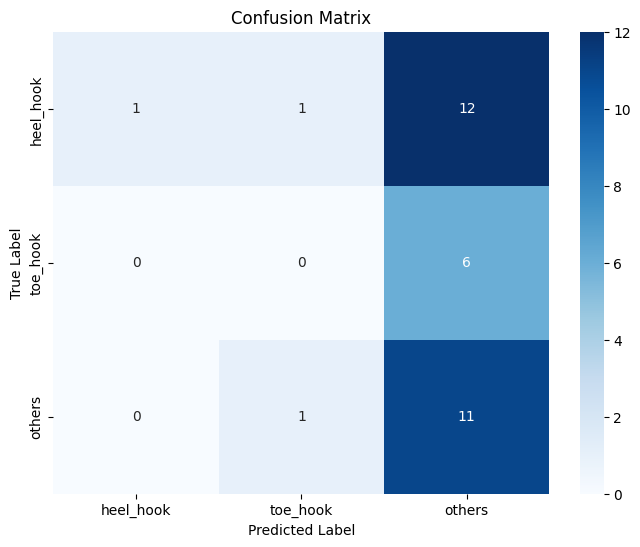

In [29]:
# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [30]:
# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=label_map.keys())
print(report)

              precision    recall  f1-score   support

   heel_hook       1.00      0.07      0.13        14
    toe_hook       0.00      0.00      0.00         6
      others       0.38      0.92      0.54        12

    accuracy                           0.38        32
   macro avg       0.46      0.33      0.22        32
weighted avg       0.58      0.38      0.26        32

